In [26]:
%matplotlib inline

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

Shape of training data: (50000, 32, 32, 3)
Shape of training labels: (50000, 1)
Shape of test data: (10000, 32, 32, 3)
Shape of test labels: (10000, 1)
----------


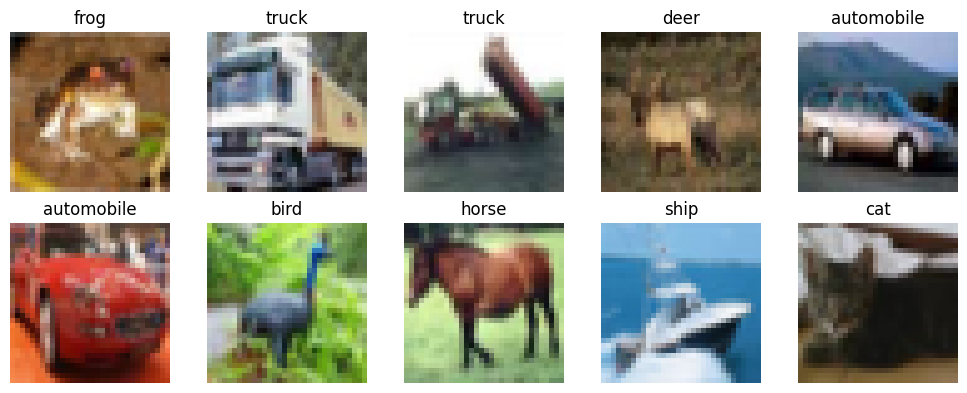

In [28]:
# Read in the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the training data

x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

print("Shape of training data:", x_train.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of test data:", x_test.shape)
print("Shape of test labels:", y_test.shape)
print("----------")

# sizeOfXtrain = x_train.shape[0]
#print("Number of samples in dataset : ",sizeOfXtrain)

# Establish the parameters to be used in this model

params = {
    'filters_layer1': 32,
    'filters_layer2': 64,
    'filters_layer3': 128,
    'kernel_size': 3,
    'epochs': 100,
    'batch_size': 128,
     'blur_kernel': [5, 5]
}



# Class names for labels (optional)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plot first 10 images without blur
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')

plt.tight_layout()
plt.show()

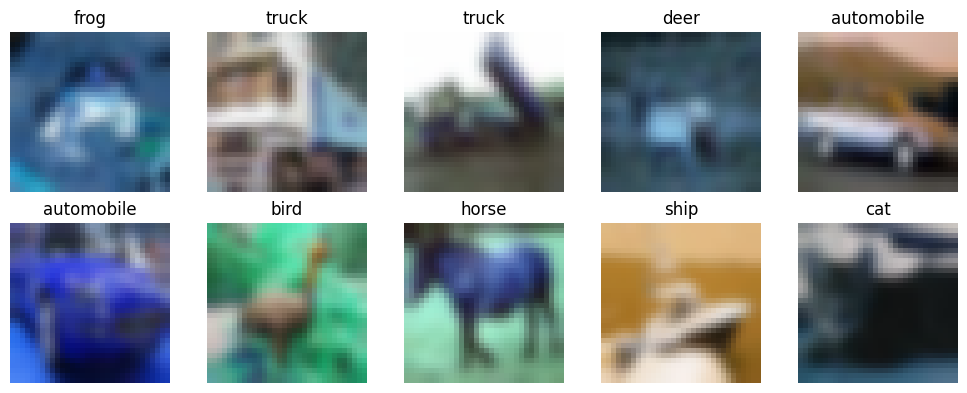

In [29]:
# Apply the blur
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Note cv2 uses BGR format and  matplotlib expects RGB
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(x_train[i], cv2.COLOR_BGR2RGB)
    blurred_image = cv2.GaussianBlur(image_rgb,params['blur_kernel'],0)
    plt.imshow(blurred_image)
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
def blur_images(images):
    blurred = []
    for img in images:
        img = cv2.GaussianBlur(img,params['blur_kernel'], 0)
        blurred.append(img)
    return np.array(blurred)

x_train_blurred = blur_images(x_train)
x_test_blurred  = blur_images(x_test)

# Determining Number of Layers

* Complexity of the data and the desired level of abstraction dictate the choice.
## General Guideline for Building an Autoencoder
* Simple Autoencoder:
  - 3-4 layers (2 Convolutional and 2 fully connected)
  - Great to use to detect basic features like:
    - Lines
    - Edges
    - Shapes
* Moderate Autoencoder:
  - 5-6 layers (3 Convolutional and 3 fully connected)
  - Good starting point for most datasets
  - Allows network to learn more abstract features while still being computationally efficient
<br>
---

# Kernel Size

The kernel size in convolutional layers depends on the spatial dimensions of your input data and the desired level
of feature extraction. Here are some general guidelines:

- **Small Input Data**: Use smaller kernel sizes (`3x3`, `5x5`)
  - These will help reduce the number of parameters and computations while still capturing useful features.
- **Medium Input Data**: Use medium-sized kernel sizes (7x7, 9x9)
  - This is a good starting point for most datasets. It will allow the network to learn both local and global feature
    capabilities.
- **Large Input Data**: Use larger kernel sizes (11x11, 13x13)
  - These will help capture more complex features, but may lead to overfitting if not regularized properly.

<br>

---

# Number of `MaxPooling` layers to use
- Depends on 
  - The inputsize of the images 
    - Remember CIFAR-10 is 32x32x3
  - How much compression you want 
    - But make sure not to go to small for it to be useful
- Each `MaxPooling2D(pool_size=2)` cuts width/height in `half`
  - So after two layers : 32x32 --> 16x16 --> 8x8
  - This is good enough spatial size to compress further with Dense layers if needed

## Rule of thumb
- 1-2 pooling layers are great for small images like CIFAR-10
- Don't pool to many times so that the feature map becomes `1x1`

In [31]:

# Encoder
input_img = Input(shape=(32, 32, 3))
x = Conv2D(params['filters_layer1'], (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)  # 16x16
x = Conv2D(params['filters_layer2'], (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)  # 8x8
x = Conv2D(params['filters_layer2'], (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  # 4x4

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)  # 8x8
x = Conv2D(params['filters_layer2'], (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # 16x16
x = Conv2D(params['filters_layer1'], (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # 32x32
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


# Interpreting `autoencoder.summary()` result


### Columns


| Column        | Meaning |
| ---          | ---    |
| Layer (type)  | Name and type of layer (e.g. Conv2D, Dense, MaxPooling2D, etc.) |
| Output Shape   | Shape of the output from that layer. (None, 32, 32, 3) means: batch size is flexible (None),
then height 32, width 32, and 3 channels (RGB). |
| Param #        | Number of trainable parameters (weights + biases) in that layer |

### Terms to Know

*   **Conv2D**: Applies filters to input; each filter adds weights and a bias = trainable params.
*   **MaxPooling2D**: Downsamples input by selecting the max value — no trainable parameters.
*   **Dense**: Fully connected layer — lots of parameters (especially after flattening).
*   **Conv2DTranspose**: Used in the decoder — upsamples back to original image size.
*   **Total params**: Sum of all weights and biases you're training.
*   **Trainable params**: Subset of total — usually equal unless you freeze some layers.

### Key Things to Watch For

*   Are shapes shrinking in encoder and growing in decoder? That’s the compression/decompression behavior of
autoencoders.
*   Check output shape of the final layer — should match your input image (32, 32, 3) for CIFAR-10.
*   Parameter count — helps you gauge complexity. Too high? Overfitting risk. Too low? Might underfit.

In [32]:
# Build the model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,299 (872.26 KB)

 Trainable params: 223,299 (872.26 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train the Autoencoder
history = autoencoder.fit(
    x_train_blurred, x_train,  # training noisy images vs. clean targets
    epochs=params['epochs'],
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_blurred, x_test)
)
# print(history.history.keys())



Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.0262 - val_loss: 0.0107
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0104 - val_loss: 0.0090
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0080 - val_loss: 0.0074
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 10/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 11/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 12/100
391/391 ━━━━━━━━

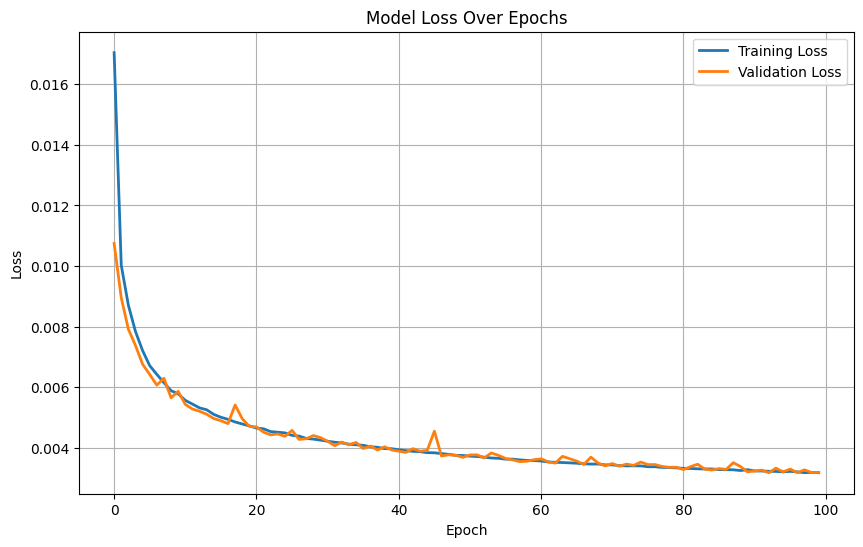

In [34]:
import matplotlib.pyplot as plt

# run_id = 'run_01'  # or use datetime strings, hyperparam info, etc.
# plt.savefig(f'{run_id}_loss_plot.png', dpi=300)


# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the figure
# plt.savefig('loss_plot.png', dpi=300)
plt.show()


In [35]:
for i, loss in enumerate(history.history['val_loss']):
    print(f"Epoch [ {i+1} ] : val_loss = {loss}")
val_loss = history.history['val_loss'][-1]
print("Val loss :",val_loss)


Epoch [ 1 ] : val_loss = 0.01074347272515297
Epoch [ 2 ] : val_loss = 0.008956153877079487
Epoch [ 3 ] : val_loss = 0.007915030233561993
Epoch [ 4 ] : val_loss = 0.007376798428595066
Epoch [ 5 ] : val_loss = 0.006758396048098803
Epoch [ 6 ] : val_loss = 0.006418835371732712
Epoch [ 7 ] : val_loss = 0.006067668553441763
Epoch [ 8 ] : val_loss = 0.006293572019785643
Epoch [ 9 ] : val_loss = 0.0056479559279978275
Epoch [ 10 ] : val_loss = 0.0058621931821107864
Epoch [ 11 ] : val_loss = 0.005431513302028179
Epoch [ 12 ] : val_loss = 0.005279533565044403
Epoch [ 13 ] : val_loss = 0.0052046761848032475
Epoch [ 14 ] : val_loss = 0.005105961579829454
Epoch [ 15 ] : val_loss = 0.00496435584500432
Epoch [ 16 ] : val_loss = 0.004892805125564337
Epoch [ 17 ] : val_loss = 0.004795325919985771
Epoch [ 18 ] : val_loss = 0.0054120565764606
Epoch [ 19 ] : val_loss = 0.004960422404110432
Epoch [ 20 ] : val_loss = 0.0047054653987288475
Epoch [ 21 ] : val_loss = 0.004688482265919447
Epoch [ 22 ] : val_los

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


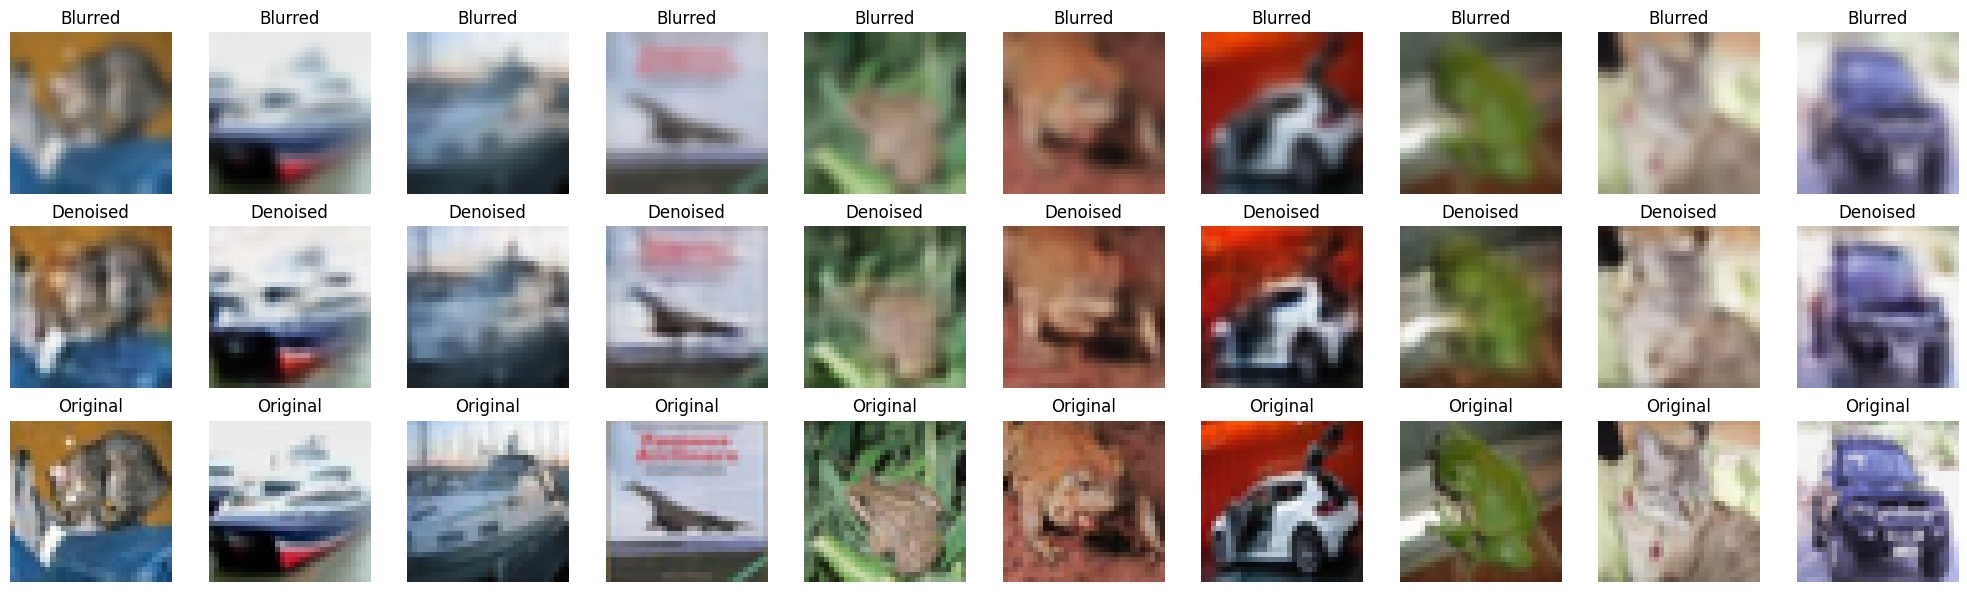

In [38]:
# Visualize the results
decoded_imgs = autoencoder.predict(x_test_blurred[:10])

plt.figure(figsize=(20, 6))
for i in range(10):
    # Blurred input
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(x_test_blurred[i])
    plt.title("Blurred")
    plt.axis("off")

    # Output (Denoised)
    ax = plt.subplot(3, 10, i + 11)
    plt.imshow(decoded_imgs[i])
    plt.title("Denoised")
    plt.axis("off")

    # Ground Truth
    ax = plt.subplot(3, 10, i + 21)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

plt.tight_layout()
plt.savefig("comparison_grid.png", dpi=300)  # ⬅️ Save figure as image
plt.show()

In [37]:
import csv
from datetime import datetime
import os
from PIL import Image

def log_experiment(params, val_loss, filename='experiment_log.csv'):
    file_exists = os.path.isfile(filename)
    
    with open(filename, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=list(params.keys()) + ['val_loss'])
        if not file_exists:
            writer.writeheader()
        writer.writerow({**params, 'val_loss': val_loss})

# params = {
#     'filters_layer1': 32,
#     'filters_layer2': 64,
#     'kernel_size': 3,
#     'epochs': 10,
#     'batch_size': 128,
#     'blur_kernel': 5
# }
log_experiment(params, val_loss)

# def save_images(blurred, denoised, original, save_dir='results'):
#     timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
#     exp_dir = os.path.join(save_dir, f'exp_{timestamp}')
#     os.makedirs(exp_dir, exist_ok=True)

#     for i in range(len(blurred)):
#         Image.fromarray((blurred[i] * 255).astype('uint8')).save(f"{exp_dir}/blurred_{i}.png")
#         Image.fromarray((denoised[i] * 255).astype('uint8')).save(f"{exp_dir}/denoised_{i}.png")
#         Image.fromarray((original[i] * 255).astype('uint8')).save(f"{exp_dir}/original_{i}.png")
# save_images(x_test_blurred[:10], decoded_imgs, x_test[:10])


# Things to experiment with
### Experimentation Ideas

#### 1. Blur levels and kernel size
Try different blur levels by changing the kernel size in `cv2.GaussianBlur()`

#### 2. Tuning Encoder/Decoder Settings
Tweak the number of filters and layers in the encoder/decoder

#### 3. Adding Noise
Add noise like salt-and-pepper instead of blur

#### 4. Increased Training Time
Try training for more epochs
Started out with 10

#### 5. Visualizing Intermediate Activations
Visualize intermediate activations with `Model(inputs=input_img, outputs=some_layer).predict(...)`